# California mock grid using solar power

An example of a grid with three nodes (northern California, Los Angeles metropolitan area, and the rest of southern California) alimented by a single solar power generator, with four storage units. We use real load data, from CalISO, and real insolation data, from NREL. 

In [1]:
%matplotlib inline
import datetime
import pandas as pd
import matplotlib
import numpy as np
import cvxpy as cvx
from matplotlib import pyplot as plt

# import local copy of cvxpower
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from cvxpower import *

matplotlib.rc("figure", figsize=(16,6))
matplotlib.rc("lines", linewidth=2)
matplotlib.rc("font", serif='Computer Modern Roman')

graphdir = '../fig/'
figsize=(10,2)

## Load data

In [2]:
data = pd.read_excel('HistoricalEMSHourlyLoad_2014-2016.xlsx', index_col=0, parse_dates=[0])

In [3]:
data.head()

,Date,HE,PGE,SCE,SDGE,VEA,CAISO Total
Dates,,,,,,,
2014-01-01 00:00:00,2014-01-01,1,10057,9862,2096,58,22073
2014-01-01 01:00:00,2014-01-01,2,9707,9530,1986,59,21283
2014-01-01 02:00:00,2014-01-01,3,9438,9200,1936,61,20635
2014-01-01 03:00:00,2014-01-01,4,9309,9015,1896,64,20283
2014-01-01 04:00:00,2014-01-01,5,9319,8987,1899,67,20271


In [22]:
norcal = data['PGE']/1000#000. # in TWh
la = data['SCE']/1000#000.  # in TWh
socal = data['SDGE']/1000#000.  # in TWh

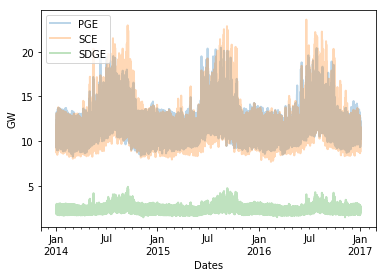

In [23]:
norcal.plot(alpha=.3)
la.plot(alpha=.3)
socal.plot(alpha=.3)
plt.ylabel('GW')
plt.legend()

## Approximate solar generator profile 

In [233]:
T = 24 * 365 #24 * 7 * 4
timedeltas = (norcal.index[:T] - pd.datetime(2014,1,1))
seconds = pd.Series(index=norcal.index[:T], 
                    data=pd.to_datetime(np.array(timedeltas)).astype(int)*1E-9)
#seconds.plot()

In [234]:
annual_profile = (.3 + pd.Series(index = norcal[:T].index, data= 
          np.maximum(np.cos(2 * np.pi * seconds / (24*3600*365)  + np.pi) + 1.,0.))/2.5)
#annual_profile.plot()

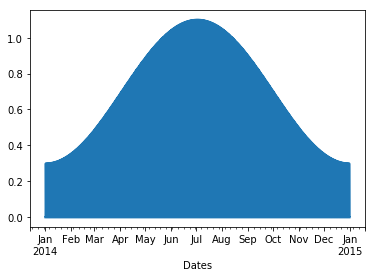

In [235]:
power_max_profile = pd.Series(index = norcal[:T].index, 
                              data=np.maximum(np.cos(2 * np.pi * seconds / (24*3600)  + np.pi),0.))

power_max_profile *= annual_profile

power_max_profile.plot()

## Define grid 

#### Devices 

In [236]:
###
## units are GW / GWh .
## 
###

load_norcal = FixedLoad(power=np.matrix(norcal[:T]).T, name='norcal load')
load_la = FixedLoad(power=np.matrix(la[:T]).T, name='la load')
load_socal = FixedLoad(power=np.matrix(socal[:T]).T, name='socal load')

# storage_norcal = Storage(discharge_max=norcal.mean(), 
#                          charge_max=norcal.mean(), 
#                          energy_max=norcal.mean()*2, 
#                         energy_init= norcal.mean(),
#                          energy_final=norcal.mean(),
#                         name='norcal_storage')
# storage_la = Storage(discharge_max=la.mean()/2, 
#                          charge_max=la.mean()/2, 
#                          energy_max=la.mean(), 
#                         energy_init= la.mean()/2,
#                          energy_final=la.mean()/2,
#                         name='la_storage')
# storage_socal = Storage(discharge_max=socal.mean(), 
#                          charge_max=socal.mean()/2, 
#                          energy_max=socal.mean(), 
#                         energy_init= socal.mean()/2,
#                          energy_final=socal.mean()/2,
#                         name='socal_storage')

max_total_load = (norcal + socal + la).max()
mean_total_load = (norcal + socal + la).mean()

storage_central = Storage(energy_init=mean_total_load,
                          energy_final=mean_total_load,
                          discharge_max=mean_total_load, 
                          charge_max=mean_total_load, 
                          energy_max=mean_total_load*6, 
                          name='central_storage')

gen = Generator(power_min=0., power_max = max_total_load*2., alpha=1., 
                beta=80000.)
solar = Generator(power_max=np.matrix(3 * mean_total_load * power_max_profile).T,
                power_min = 0.,
                alpha=0., beta=.0) ## todo get solar profile

trans_norcal = TransmissionLine()#power_max=15)
trans_la = TransmissionLine()#power_max=15)
trans_socal = TransmissionLine()#power_max=8)

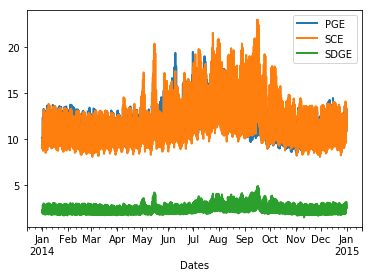

In [237]:
norcal[:T].plot()
la[:T].plot()
socal[:T].plot()
plt.legend()

#### Network 

In [ ]:
norcal_net = Net([load_norcal.terminals[0], trans_norcal.terminals[0], 
                 # storage_norcal.terminals[0]
                 ])
la_net = Net([load_la.terminals[0], trans_la.terminals[0],
             # storage_la.terminals[0]
             ])
socal_net = Net([load_socal.terminals[0], trans_socal.terminals[0], 
                # storage_socal.terminals[0]
                ])

gen_net = Net([gen.terminals[0], 
               solar.terminals[0],
               trans_norcal.terminals[1],
                trans_la.terminals[1],
               trans_socal.terminals[1],
               storage_central.terminals[0]
              ])

network = Group([load_norcal,
                 load_la,
                 load_socal,
                 gen, 
                 # storage_norcal,
                 #storage_la,
                # storage_socal,
                storage_central,
                trans_norcal,
                trans_la,
                trans_socal,
                 solar
                ], 
                [norcal_net, gen_net, la_net, socal_net
                ])


network.init_problem(time_horizon=T)
network.problem.solve(verbose=True, solver='ECOS')

In [ ]:
fig = network.results.plot(norcal[:T].index, figsize=(18, 10))
(-power_max).plot(ax=fig[0], label='power_max')
#plt.legend()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,3))
# ax.plot(norcal[:T+1].index, storage_norcal.energy.value, label='storage norcal')
# ax.plot(norcal[:T+1].index ,storage_la.energy.value, label='storage la')
# ax.plot(norcal[:T+1].index, storage_socal.energy.value, label='storage socal')
ax.plot(norcal[:T+1].index, storage_central.energy.value, '.-', label='storage central')
ax.plot(norcal[:T+1].index, [storage_central.energy_max]*(T+1), '--', label='storage max')


ax.legend()

ax.set_ylabel("stored energy")

In [ ]:
pd.Series(index=norcal.index[:T], data=gen.terminals[0].power_var.value.flatten()).plot(alpha=.5)
pd.Series(index=norcal.index[:T], data=solar.terminals[0].power_var.value.flatten()).plot(alpha=.5)

In [ ]:
print('Mean solar power %.2fGW' %(-np.mean(solar.terminals[0].power_var.value)))
print('Mean gas power %.2fGW' %(-np.mean(gen.terminals[0].power_var.value)))